In [2]:
import pandas as pd
import pickle

import matplotlib.pyplot as plt

from review_tools import extract_review, lemmatize

In [3]:
with open('df_with_patch_object.pickle', 'rb') as f:
    patch_responses = pickle.load(f)

In [4]:
reviews = patch_responses[patch_responses['email'].notnull()][patch_responses['self_response'] == False]
reviews.drop(['self_response', 'Patch'], inplace=True, axis=1)

<ipython-input-4-870f016a55f3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reviews = patch_responses[patch_responses['email'].notnull()][patch_responses['self_response'] == False]


In [5]:
reviews.count()

Unnamed: 0         158200
patch_id           158200
response_author    158200
resp_parent        158200
resp_msg_id        158200
upstream            17293
response_is_bot    158200
bot_name            16077
patch_author       158200
responder          158200
email              158200
dtype: int64

In [6]:
reviews['payload'] = reviews['email'].map(extract_review)

In [7]:
reviews['email'][3].get_payload()

"\nOn 4/21/20 5:21 PM, Jason Gunthorpe wrote:\n> From: Jason Gunthorpe <jgg@mellanox.com>\n> \n> The API is a bit complicated for the uses we actually have, and\n> disucssions for simplifying have come up a number of times.\n> \n> This small series removes the customizable pfn format and simplifies the\n> return code of hmm_range_fault()\n> \n> All the drivers are adjusted to process in the simplified format.\n> I would appreciated tested-by's for the two drivers, thanks!\n\nFor nouveau you can add:\nTested-by: Ralph Campbell <rcampbell@nvidia.com>\n\n"

In [8]:
reviews['payload'][3]

['On 4/21/20 5:21 PM, Jason Gunthorpe wrote:',
 'For nouveau you can add:',
 'Tested-by: Ralph Campbell <rcampbell@nvidia.com>']

In [9]:
reviews.iloc[45].email.get_payload().split('\n')

['Hi Johnny,',
 '',
 'On Wed, Aug 28, 2019 at 10:33:46AM +0800, Johnny.Chuang wrote:',
 '> The return value of elants_i2c_initialize() was always 0.',
 '> It maybe register input device when initialize fail.',
 '',
 'We do not want to return error here, because it will abort probe, and',
 'then we will not be able to initiate firmware flash flow so we can',
 'attempt to recover the device.',
 '',
 'If you want to try you can change the ts->iap_mode before trying to',
 'register input device, but then you need to be very careful about',
 'registering and unregistering it later, after flashing or re-flashing',
 'firmware.',
 '',
 '> ',
 '> Signed-off-by: Johnny Chuang <johnny.chuang@emc.com.tw>',
 '> ---',
 '>  drivers/input/touchscreen/elants_i2c.c | 2 +-',
 '>  1 file changed, 1 insertion(+), 1 deletion(-)',
 '> ',
 '> diff --git a/drivers/input/touchscreen/elants_i2c.c',
 '> b/drivers/input/touchscreen/elants_i2c.c',
 '> index d4ad24e..9c9816f 100644',
 '> --- a/drivers/input/touchscr

In [10]:
reviews.drop('email', axis=1, inplace=True)

In [11]:
reviews['payload'].iloc[45]

['Hi Johnny,',
 'On Wed, Aug 28, 2019 at 10:33:46AM +0800, Johnny.Chuang wrote:',
 'We do not want to return error here, because it will abort probe, and',
 'then we will not be able to initiate firmware flash flow so we can',
 'attempt to recover the device.',
 'If you want to try you can change the ts->iap_mode before trying to',
 'register input device, but then you need to be very careful about',
 'registering and unregistering it later, after flashing or re-flashing',
 'firmware.',
 'Thanks.',
 '--',
 'Dmitry']

In [12]:
lemmatize(reviews['payload'].iloc[45])

'hi johnny we do not want to return error here because it will abort probe and then we will not be able to initiate firmware flash flow so we can attempt to recover the device if you want to try you can change the t > iap mode before trying to register input device but then you need to be very careful about registering and unregistering it later after flashing or re flashing firmware thanks dmitry'

In [13]:
reviews['payload'] = reviews['payload'].map(lemmatize)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

vectorizer = TfidfVectorizer(max_df=0.5, max_features=80,
                                 min_df=2, stop_words='english',
                                 use_idf=True)
subset_reviews = reviews.sample(10000)
data_corpus = subset_reviews['payload']

X = vectorizer.fit_transform(data_corpus) 

svd = TruncatedSVD(n_components=50)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

Explained variance percentage after SVD:

In [15]:
explained_variance = svd.explained_variance_ratio_.sum() * 100
explained_variance 

98.852077501283

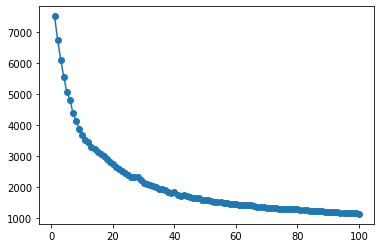

In [16]:
from sklearn.cluster import KMeans
sse = {}

for k in range(1, 101):
    kmeans = KMeans(n_clusters=k).fit(X)
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.show()

In [17]:
num_clusters = 10

In [18]:
kmeans = KMeans(n_clusters=num_clusters).fit(X)

subset_reviews.loc[:,"clusters"] = kmeans.labels_

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: add cgi bug bsd arm cpu gfx ctx device git drm intel http infradead gitlab listinfo id issues freedesktop dmesg
Cluster 1: add arm change com devel device bugs drm igt fail hsw exec gem cursor int fi http iclb list issues
Cluster 2: apl add bug com ctx device change drm cursor ci flip html git gitlab linux exec fail fi gfx iclb
Cluster 3: basic add bsd drivers dmesg drm igt fdo ci com http cpu gfx hsw intel fail cursor flip infradead frontbuffer
Cluster 4: ci bsd bug add arm basic com exec cursor apl fi flip dev gem device id frontbuffer gitlab fdo drivers
Cluster 5: add bugs basic bug cgi ctx change com crc dev drivers dmesg hsw linux http intel id ci fi fdo
Cluster 6: apl add bugs bsd cgi dev change drivers devel fdo kernel issues gitlab flip html frontbuffer cpu dmesg igt kbl
Cluster 7: arm apl add basic com devel bugs drivers fail flip dev fdo dmesg change freedesktop gem ctx hsw frontbuffer html
Cluster 8: change basic cgi bsd add com device devel dev html crc freedeskt

In [19]:
kmeans.inertia_

3827.7968464042046

In [20]:
subset_reviews.groupby('clusters').size()

clusters
0     732
1    1486
2    1028
3     792
4    2953
5     692
6     675
7     918
8     435
9     289
dtype: int64

In [21]:
def get_active_days(line):
    try:
        return (pd.to_datetime(line['Activity End']) - pd.to_datetime(line['Activity Start'])).days
    except:
        return None

def get_num_commits(Commits):
    try:
        return int(Commits)
    except:
        return None

developer_stats = pd.read_csv('developers_all.csv')
developer_stats['Active'] = developer_stats.apply(get_active_days, axis=1)
developer_stats['Name'] = developer_stats['Name'].str.lower()
developer_stats['Commits'] = developer_stats['Commits'].map(get_num_commits)

In [30]:
subset_reviews['Name'] = subset_reviews['response_author'].str.extract('(.*) <.*>').fillna('')
subset_reviews['Name'] = subset_reviews['Name'].map(lambda x: str.lower(x))

In [32]:
subset_reviews = pd.merge(subset_reviews, developer_stats, on='Name', how='left')
subset_reviews.head()

,Unnamed: 0,patch_id,response_author,resp_parent,resp_msg_id,upstream,response_is_bot,bot_name,patch_author,responder,...,Commits,Changed Lines,Lines Removed,Signoffs,Reviews,Test Credits,Test Credits Given,Report Credits,Report Credits Given,Active
0,131927,<20200324061050.14845-5-manivannan.sadhasivam@...,Jeffrey Hugo <jhugo@codeaurora.org>,<20200324061050.14845-5-manivannan.sadhasivam@...,<0c9be20f-c349-a5b7-cbf8-a3edaffc2d70@codeauro...,NaN,False,NaN,"('manivannan sadhasivam', 'manivannan.sadhasiv...","('jeffrey hugo', 'jhugo@codeaurora.org')",...,105.0,6805.0,603.0,111.0,74.0,33.0,6.0,3.0,7.0,1368.0
1,179031,<20200723105615.1268126-1-npiggin@gmail.com>,Peter Zijlstra <peterz@infradead.org>,<20200723105615.1268126-1-npiggin@gmail.com>,<20200725202617.GI10769@hirez.programming.kick...,NaN,False,NaN,"('nicholas piggin', 'npiggin@gmail.com')","('peter zijlstra', 'peterz@infradead.org')",...,1206.0,57892.0,34507.0,2108.0,22.0,4.0,70.0,21.0,163.0,2887.0
2,87710,<20191031162030.31158-1-idosch@idosch.org>,Jakub Kicinski <jakub.kicinski@netronome.com>,<20191031162030.31158-1-idosch@idosch.org>,<20191031092338.79831fa7@cakuba.netronome.com>,NaN,False,NaN,"('ido schimmel', 'idosch@idosch.org')","('jakub kicinski', 'jakub.kicinski@netronome.c...",...,1306.0,96289.0,37985.0,1765.0,487.0,14.0,30.0,35.0,43.0,3135.0
3,63234,<20190812173048.9186-15-logang@deltatee.com>,hch@lst.de (Christoph Hellwig),<20190812173048.9186-15-logang@deltatee.com>,<20190816081616.GN9249@lst.de>,NaN,False,NaN,"('logan gunthorpe', 'logang@deltatee.com')","('christoph hellwig', 'hch@lst.de')",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,187381,<c629a9ef-3867-c3d1-f6c9-2c3b0e4ac68a@infradea...,Jonathan Corbet <corbet@lwn.net>,<c629a9ef-3867-c3d1-f6c9-2c3b0e4ac68a@infradea...,<20200525103126.60941f34@lwn.net>,4eb9241127a0b5ac3aaaf1b246728009527ebc86,False,NaN,"('randy dunlap', 'rdunlap@infradead.org')","('jonathan corbet', 'corbet@lwn.net')",...,392.0,28842.0,14829.0,2663.0,2.0,1.0,1.0,8.0,25.0,5284.0


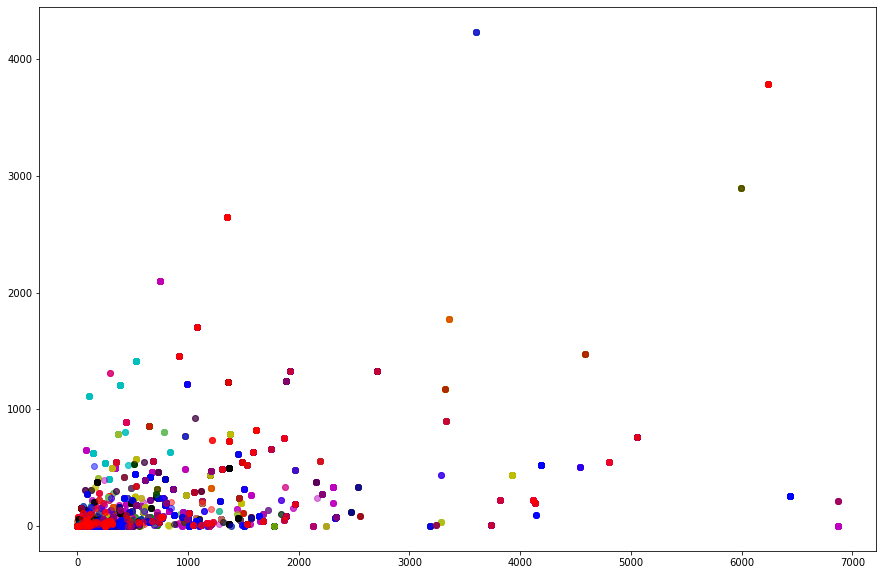

In [41]:
import itertools

fig, ax = plt.subplots(figsize=(15, 10))

colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
for i in range(num_clusters):
    plt.scatter(subset_reviews[subset_reviews['clusters']==i]['Commits'], 
            subset_reviews[subset_reviews['clusters']==i]['Reviews'], 
                color=next(colors), alpha=0.5)
    